## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [References](#References:)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
#df.count()
#df.shape[0]
len(df)

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [6]:
(df.converted == 1).mean()
#df[df['converted']==1].count()/df.count()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
x = df[(df['landing_page']=='new_page') & (df['group']=='control')].count()[1]
y = df[(df['landing_page']=='old_page') & (df['group']=='treatment')].count()[1]
total_mismatch = x+y
total_mismatch

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# can be done also using bitwise xor 
df2 = df[~((df['landing_page']=='new_page') & (df['group']=='control'))]
df2 = df2[~((df['landing_page']=='old_page') & (df['group']=='treatment'))]
df2.size

<ipython-input-10-f32c7c6cc788>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[~((df['landing_page']=='old_page') & (df['group']=='treatment'))]


1452925

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]
#x = df2[(df2['landing_page']=='new_page') & (df2['group']=='control')].count()[1]
#y = df2[(df2['landing_page']=='old_page') & (df2['group']=='treatment')].count()[1]
#total_mismatch = x+y
#total_mismatch

0

In [12]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(index=1899,inplace=True) #drop the old timestamp
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
(df2.converted==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
#P(Converted|Control) = P(Converted & Control) / P(Control)
#len(df2.query("group=='control' and converted==1"))  / len(df2[df2.group == 'control'])
#len(df2[(df2.group == 'control')&(df2.converted==1)])  / len(df2[df2.group == 'control'])
df2[(df2.group == 'control')&(df2.converted==1)].shape[0]  / df2[df2.group == 'control'].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
#P(Converted|Treatment) = P(Converted & Treatment)/P(Treatment)
df2[(df2.group == 'treatment')&(df2.converted==1)].shape[0]  / df2[df2.group == 'treatment'].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:**

No.

P(Conversion) = 0.11959708724499628

P(Conversion|Control group) = P(Conversion|Old Page) = 0.1203863045004612 -->is becoming greater a little bit

P(Conversion|Treatment group) = P(Conversion|New Page) = 0.11880806551510564 -->is reduced a little bit

P(Treatment group) = P(New Page) = 0.50006194422266881

P(New Page|Conversion) = P(Conversion|New Page).P(New Page) / P(Conversion) = 0.49676731

P(Old Page|Conversion) = 1-P(New Page|Conversion) = 0.50323269

There is no significance difference between the 2 pages


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$H_{0}$: **$p_{old}$** >= **$p_{new}$** <br> **$p_{old}$** - **$p_{new}$** >= 0 <br> **$p_{new}$** - **$p_{old}$** < =0

$H_{1}$: **$p_{old}$** < **$p_{new}$**  <br> **$p_{old}$** - **$p_{new}$** < 0 <br> **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
#n = len(df2[df2['converted']==1])
#sample_new = []
#sample_old = []
##sample_new = df2.sample(n)
##sample_old = df2.sample(n)
#diffs = []
#for i in range(10000):
#    bootstrap_sample = df2.sample(n, replace=True)
#    sample_new_1 = bootstrap_sample[bootstrap_sample['group']=='treatment']['converted'].mean()
#    sample_old_1 = bootstrap_sample[bootstrap_sample['group']=='control']['converted'].mean()
#    sample_new.append(sample_new_1)
#    sample_old.append(sample_old_1)
#    diffs.append(sample_new_1 - sample_old_1)
#np.mean(sample_new)
(df2.converted == 1).mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
#np.mean(sample_old)
(df2.converted == 1).mean()

0.11959708724499628

At the null hypothesis, there is no difference in conversion based on the page, which means the conversions for each page are the same and is equal to the conversion rate in general.

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
len(df2[df2['group']=='treatment'])

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
len(df2[df2['group']=='control'])

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(145310, 0.11959708724499628)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(145274, 0.11959708724499628)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted - old_page_converted #This value changes every run

-148

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
new_page_converted = np.random.binomial(145310, 0.11959708724499628, 10000)
old_page_converted = np.random.binomial(145274, 0.11959708724499628, 10000)
p_diffs = new_page_converted - old_page_converted
p_diffs

array([-177,  229,  -61, ...,  114,  -28,  -77])

i. Plot a histogram of the **p_diffs**.  


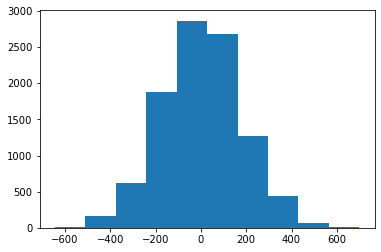

In [29]:
plt.hist(p_diffs);

Notice that the plot looks like normal distribution as expected according to the Central Limit Theorem

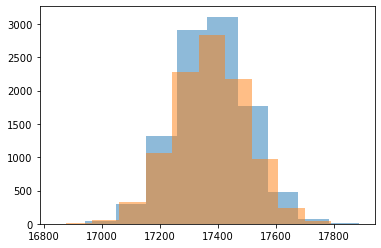

In [30]:
plt.hist(new_page_converted, alpha=0.5);
plt.hist(old_page_converted, alpha=0.5);

In [31]:
p_std = p_diffs.std() #This value changes a little bit every run
p_std

176.10569039573934

In [32]:
#we will consider all the dataset as an observed sample
observed_new_page_converted = 0.11880806551510564*145310
observed_old_page_converted = 0.1203863045004612*145274
observed_diff = observed_new_page_converted - observed_old_page_converted

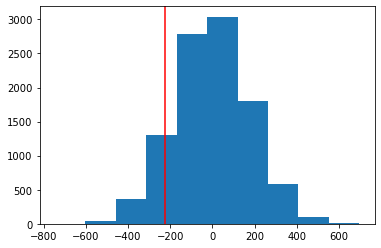

In [33]:
null_values = np.random.normal(0, p_std, 10000)
plt.hist(null_values);
plt.axvline(observed_diff, color="red");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
(null_values > observed_diff).mean()

0.8971

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**
This the p_value. It is too large. Therefore, we would decide to remain on the old page as there is no statistical evidence to reject the null hypothesis (the old page gives more or equal conversion rate than the new page).

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm
import statsmodels.stats.proportion as stats
convert_old = observed_old_page_converted
convert_new = observed_new_page_converted
n_old = 145274
n_new = 145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
#count = number of conversions in both old and new page
#nobs = total number of users who have the old page and the new page respectively
#value = value of diff under the null hypothesis
#alternative = smaller since the alternative hypothesis is p_old < p_new
z_score, p_value = stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old, n_new], value=0, alternative="smaller")
(z_score, p_value)

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**<br>
Yes.<br> 
The p-value is approximately 0.9 in parts j and k.<br>
See the histogram above with the red line<br>
The z-score is greater than 1, because the observed difference was shifted slightly to the left, therefore the right area is graeter than 0.5 and the left area to its negative (its negative is in the right side) is also greater than 0.5, so the sum of both areas is greater than 1.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
Logistic Regression


In [37]:
df2['intercept']=1
#df2['ab_page']=(df2['group']=='treatment')
#True and False will give value error while fitting the regression because they are considered categorical values
df2['ab_page'] = df2['group'].apply(lambda x:1 if x == 'treatment' else 0)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [38]:
logistic = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results_logistic = logistic.fit()
results_logistic.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-11-17 00:43 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

p-value is greater than 0.05, so the launching page (old or new) is not a significant variable in predicting conversion

In [39]:
np.exp(-0.0150)

0.9851119396030626

In [40]:
1/np.exp(-0.0150)

1.015113064615719

For treatment group, the rate of conversion is 1.0151130646157189 times more than the old page holding other variables constant.

p_value = 0.1899<br>
$H_{0}: \beta_{1}$ = 0 i.e.: The actual average change in the response (conversion) for the population with every one unit increase in the explanatory variable (old or new page) is zero. i.e. There is no statistical evidence that the population slope associated with rate of conversion in relating to the landing page (or group).<br>
$H_{1}$: $\beta_{1}$ $\neq$ 0 i.e.: The actual average change in the response (conversion) for the population with every one unit increase in the explanatory variable (old or new page) is not zero. i.e. There is statistical evidence that the population slope associated with rate of conversion in relating to the landing page (or group)<br>
When the p_value is high($\geq \alpha$), this gives us tendency to accept the null hypothesis, i.e, there is no statistical evidence that the relationship is strong.<br>
When the p_value is low (< $\alpha$), this gives us tendency to reject the null hypothesis, i.e, there is statistical evidence that there is relationship between rate of conversion and the landing page.<br>

On the other hand, in the a/b testing:<br>
The p_value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. In other words, the probability that the conversion rate of the new page is greater than the old page if we assume that the conversion rate of the old page is greater than or equal to that of the new page.

Other factors that influence whether or not an individual converts:<br>
•	change aversion: some users simply don't like change. Therefore, all users should be new or more time given should be given to old users to adjust the change.<br>
•	novelty effect: some users like to try new things.<br>
•	field of interest of the user. Therefore, we may add filed of study or job or marital status or number of children if the website is for kids or about parenting or relationships.<br>

Advantages of considering other factors to add into your regression model:<br>
•	geeting more precise model and considering more factors that may affect my decision.<br>

Disadvantages to adding additional terms into your regression model:<br>
•	Some factors may be dependant on each other such as field of study and job, givig wrong results and thus wrong interpretations.

In [41]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
countries_df = countries_df.join(pd.get_dummies(countries_df['country']))
countries_df.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [43]:
df2 = df2.join(countries_df.set_index('user_id'), on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [44]:
df2['CA'].mean()

0.04989607135974451

In [45]:
df2['UK'].mean()

0.24938055777331167

In [46]:
df2['US'].mean()

0.7007233708669438

This population is unbalanced, because the number of users from Canada, the UK, the US are not close. This may lead to false interpretations in the following logistic regression.

In [47]:
lm = sm.Logit(df2['converted'], df2[['intercept','UK','US']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-11-17 00:43 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

The data set is unbalanced. So, these interpretations may not be true.

In [48]:
lm = sm.Logit(df2['converted'], df2[['intercept','UK','US','ab_page']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-11-17 00:43 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

The p_values are greater than 0.05, so there the country and the launching page are not significant to predict rate of conversion.

In [49]:
np.exp(0.0506)

1.0519020483004984

In [50]:
np.exp(0.0408)

1.0416437559600236

In [51]:
1/np.exp(-0.0149)

1.0150115583846535

### References:

1- https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
<br>
2- The part of the z-score in: https://www.youtube.com/watch?v=zTABmVSAtT0

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1